In [16]:
#Imports
import pymysql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [2]:
# Connect to the database

conn = pymysql.connect(host='learning-1000ml.c0zbrffehjje.us-east-2.rds.amazonaws.com', 
                       port=3306, 
                       user='root1000ml', 
                       passwd='IheartData', 
                       db = 'grocery_db')

In [3]:
#Query products grouped by cust_id and prod_code_10
cust_df = pd.read_sql('select Transactions.cust_id, prod_code_10, Transactions.prod_id from Transactions \
                         left join Products on Transactions.prod_id = Products.prod_id;', conn)

In [4]:
cust_df.to_csv('customers.csv', index=False)

In [7]:
#cust_df = pd.read_csv('customers.csv')

In [8]:
#Count the number of apperances for prod_id for basket and prod_code_10
product_counts = cust_df.groupby(['cust_id', 'prod_code_10']).count().reset_index()

# Pivot table to get the prod_code_10 in columns and the sum of those products to populate sparse matrix 
row_counts = pd.pivot_table(product_counts, columns='prod_code_10', index='cust_id', values='prod_id', fill_value=0)

In [9]:
#Check number of customers
row_counts.shape

(5000, 250)

In [10]:
#Extract customers who bought at least 10 products
trim_row_counts = row_counts[row_counts.sum(axis=1)>=10]
trim_row_counts.shape

(4393, 250)

In [11]:
trim_row_counts.sum(axis=1).describe()

count    4393.000000
mean      577.820168
std       698.648019
min        10.000000
25%        67.000000
50%       291.000000
75%       840.000000
max      5309.000000
dtype: float64

We end up with 261.950 baskets with 4 or more of the 250 product types available at the store. Let's cut down the number of products available for analysis.

In [12]:
trim_row_counts.sum(axis=0).describe()

count       250.000000
mean      10153.456000
std       13927.104706
min          60.000000
25%        1239.500000
50%        5214.500000
75%       14363.250000
max      114519.000000
dtype: float64

In [13]:
114000*0.05, 114000*0.95

(5700.0, 108300.0)

In [14]:
trim_row_counts = trim_row_counts[trim_row_counts.columns[(trim_row_counts.sum(axis=0) > 5700) &
                                        (trim_row_counts.sum(axis=0) < 110000)]]

In [15]:
trim_row_counts.shape

(4393, 121)

In [17]:
count_data = trim_row_counts.values

### Apply LDA 

In [40]:
# Iterate over multiple numbers of topics and get model
no_topics = np.linspace(10,20,5, dtype='int')

all_models = []

for num in no_topics:
    mod_dict = {}
    
    #Fit the data
    mod_dict['model'] = LDA(n_components=num, n_jobs=-1, verbose=0)
    mod_dict['model'].fit(count_data)
    
    #Get metrics
    mod_dict['perplexity'] = mod_dict['model'].perplexity(count_data) 
    
    #Append to list
    all_models.append(mod_dict)
    
    print(f'Finished LDA with {num} topics')

Finished LDA with 10 topics
Finished LDA with 12 topics
Finished LDA with 15 topics
Finished LDA with 17 topics
Finished LDA with 20 topics


In [41]:
# See perplexity
all_perplexities = [mod['perplexity'] for mod in all_models]

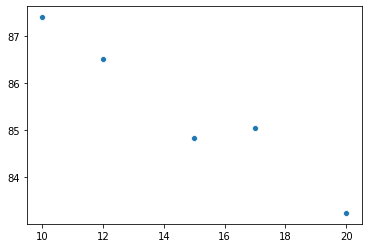

In [42]:
sns.scatterplot(x=no_topics, y=all_perplexities)

In [43]:
# Extract the labels for each model
all_labels = [mod['model'].transform(count_data).argmax(axis=1) for mod in all_models] 

In [44]:
# Get sampled silhouette score
sil_scores = [silhouette_score(count_data, labels) for labels in all_labels]
sil_scores

[-0.1029419807762656,
 -0.12296953322954753,
 -0.19649792552301062,
 -0.15479373739508684,
 -0.1819612330922394]

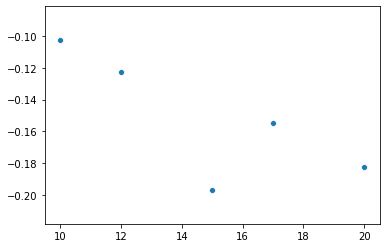

In [45]:
sns.scatterplot(y=sil_scores, x=no_topics)